In [ ]:
# Install RDKit
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import random

print(f"RDKit version: {rdkit.__version__}")

RDKit version: 2024.09.4


In [ ]:
#Load and Prepare Data
# Load dataset
url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv'
sol_df = pd.read_csv(url)

# Display first few rows of the dataset
print("Dataset head:")
display(sol_df.head())

# Convert SMILES to RDKit molecules
mol_data = [Chem.MolFromSmiles(element) for element in sol_df.SMILES]
print(f"\nTotal molecules processed: {len(mol_data)}")

Dataset head:


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl



Total molecules processed: 1144


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['measured log(solubility:mol/L)'].plot(kind='hist', bins=20, title='measured log(solubility:mol/L)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ESOL predicted log(solubility:mol/L)'].plot(kind='hist', bins=20, title='ESOL predicted log(solubility:mol/L)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Compound ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('SMILES').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='measured log(solubility:mol/L)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='measured log(solubility:mol/L)', y='ESOL predicted log(solubility:mol/L)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['measured log(solubility:mol/L)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Compound ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='Compound ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('measured log(solubility:mol/L)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['measured log(solubility:mol/L)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('SMILES')):
  _plot_series(series, series_name, i)
  fig.legend(title='SMILES', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('measured log(solubility:mol/L)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['ESOL predicted log(solubility:mol/L)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Compound ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='Compound ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('ESOL predicted log(solubility:mol/L)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['ESOL predicted log(solubility:mol/L)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('SMILES')):
  _plot_series(series, series_name, i)
  fig.legend(title='SMILES', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('ESOL predicted log(solubility:mol/L)')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['measured log(solubility:mol/L)'].plot(kind='line', figsize=(8, 4), title='measured log(solubility:mol/L)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['ESOL predicted log(solubility:mol/L)'].plot(kind='line', figsize=(8, 4), title='ESOL predicted log(solubility:mol/L)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['SMILES'].value_counts()
    for x_label, grp in _df_14.groupby('Compound ID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Compound ID')
_ = plt.ylabel('SMILES')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Compound ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='Compound ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['SMILES'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='SMILES', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Compound ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='measured log(solubility:mol/L)', y='Compound ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['SMILES'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='measured log(solubility:mol/L)', y='SMILES', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import Chem

def draw_molecules_grid(smiles_dict, n_cols=3, img_size=(300, 300)):
    """Draw molecules in a grid layout with labels"""
    mols = []
    legends = []

    # Convert SMILES to RDKit molecules
    for name, smiles in smiles_dict.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Generate 2D coordinates for the molecule
            AllChem.Compute2DCoords(mol)
            mols.append(mol)
            legends.append(name)

    # Calculate number of rows needed
    n_rows = (len(mols) + n_cols - 1) // n_cols

    # Create the grid image
    img = Draw.MolsToGridImage(mols,
                              molsPerRow=n_cols,
                              subImgSize=img_size,
                              legends=legends,
                              returnPNG=False)

    # Display using matplotlib
    plt.figure(figsize=(15, 5*n_rows))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

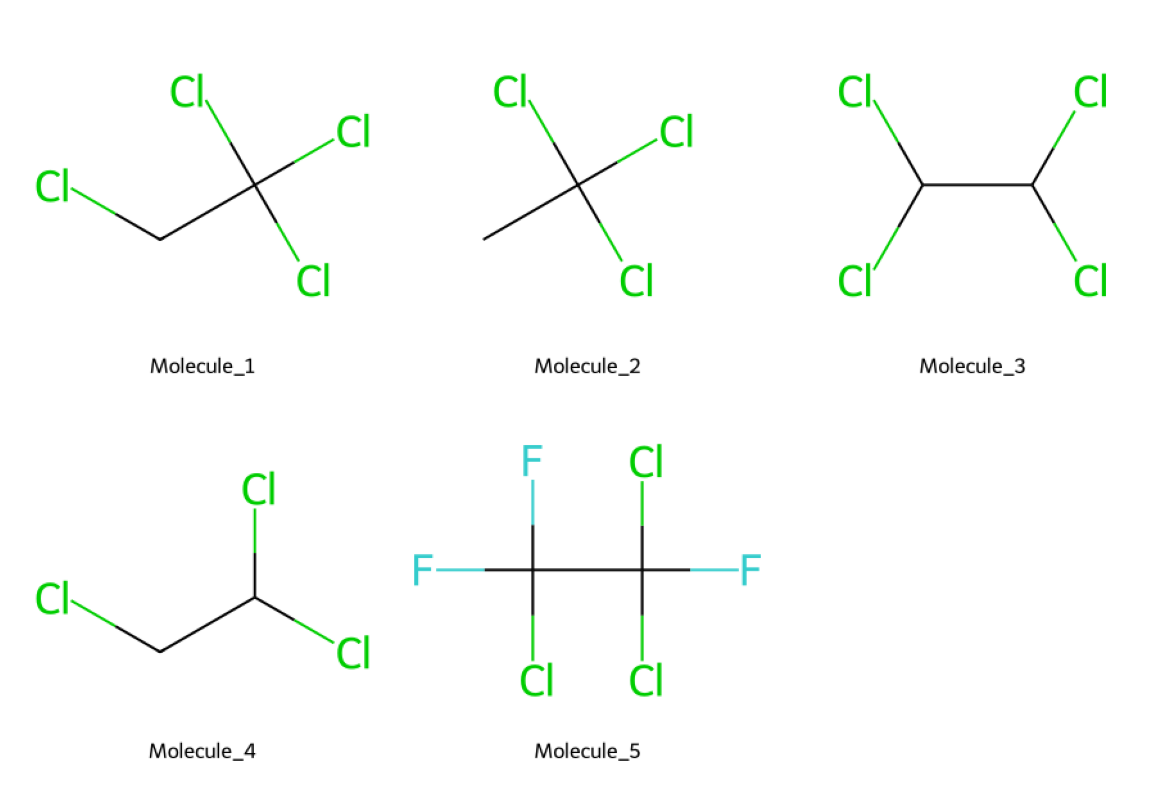

In [ ]:
sample_molecules = dict(zip(
    [f'Molecule_{i+1}' for i in range(5)],  # Names
    sol_df['SMILES'].head(5)  # SMILES strings
))

# Visualize these molecules
draw_molecules_grid(sample_molecules)

In [ ]:
#Calculate Molecular Descriptors
mol_descriptors_np = np.arange(1,1)

for mol in mol_data:
    clogP = Descriptors.MolLogP(mol)
    mol_weight = Descriptors.MolWt(mol)
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)

    row = np.array([clogP, mol_weight, num_rotatable_bonds])

    if mol_descriptors_np.size == 0:
        mol_descriptors_np = row
    else:
        mol_descriptors_np = np.vstack([mol_descriptors_np, row])

print("Molecular descriptors shape:", mol_descriptors_np.shape)

Molecular descriptors shape: (1144, 3)


In [ ]:
#Calculate Aromatic Proportion
aromatic_arr = []

for mol in mol_data:
    total_atoms = mol.GetNumAtoms()
    aromatic_count = 0
    for i in range(total_atoms):
        if mol.GetAtomWithIdx(i).GetIsAromatic():
            aromatic_count += 1

    aromatic_arr.append(aromatic_count/Descriptors.HeavyAtomCount(mol))

aromatic_np = np.array(aromatic_arr).reshape(-1,1)
print("Aromatic proportions shape:", aromatic_np.shape)

Aromatic proportions shape: (1144, 1)


In [ ]:
#Create Final Dataset
# Combine all descriptors
all_descriptors_np = np.hstack([mol_descriptors_np, aromatic_np])

# Create descriptors dataframe
descriptors_df = pd.DataFrame(all_descriptors_np,
                            columns=['cLogP', 'MolWeight', 'numRotatableBonds', 'AromaticProportion'])

# Add solubility values
descriptors_df = pd.concat([descriptors_df, sol_df["measured log(solubility:mol/L)"]], axis=1)
descriptors_df.rename(columns={'measured log(solubility:mol/L)': 'log(solubility:mol/L)'}, inplace=True)

# Display dataset info
print("Final dataset info:")
display(descriptors_df.describe())

Final dataset info:


,cLogP,MolWeight,numRotatableBonds,AromaticProportion,log(solubility:mol/L)
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,2.449133,204.631675,2.173951,0.364932,-3.057997
std,1.866003,102.620500,2.627398,0.343305,2.096502
min,-7.571400,16.043000,0.000000,0.000000,-11.600000
25%,1.414900,122.126000,0.000000,0.000000,-4.332250
50%,2.340300,183.594500,1.000000,0.375000,-2.870500
75%,3.406475,270.715750,3.000000,0.666667,-1.600000
max,10.388600,780.949000,23.000000,1.000000,1.580000


from matplotlib import pyplot as plt
_df_19['cLogP'].plot(kind='hist', bins=20, title='cLogP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['MolWeight'].plot(kind='hist', bins=20, title='MolWeight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['numRotatableBonds'].plot(kind='hist', bins=20, title='numRotatableBonds')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['AromaticProportion'].plot(kind='hist', bins=20, title='AromaticProportion')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='cLogP', y='MolWeight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='MolWeight', y='numRotatableBonds', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='numRotatableBonds', y='AromaticProportion', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26.plot(kind='scatter', x='AromaticProportion', y='log(solubility:mol/L)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27['cLogP'].plot(kind='line', figsize=(8, 4), title='cLogP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['MolWeight'].plot(kind='line', figsize=(8, 4), title='MolWeight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['numRotatableBonds'].plot(kind='line', figsize=(8, 4), title='numRotatableBonds')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['AromaticProportion'].plot(kind='line', figsize=(8, 4), title='AromaticProportion')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#Data Preparation for Modeling
# Set seed for reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# Prepare features and target
X = descriptors_df[['cLogP', 'MolWeight', 'numRotatableBonds', 'AromaticProportion']].values
Y = descriptors_df[['log(solubility:mol/L)']].values

# Normalize data
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(X)
normalized_Y = scaler.fit_transform(Y).ravel()

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, normalized_Y,
                                                    test_size=0.2, random_state=SEED)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"Y_test: {Y_test.shape}")

Data shapes:
X_train: (915, 4)
X_test: (229, 4)
Y_train: (915,)
Y_test: (229,)


Linear regression - MSE: 0.0053
Linear regression - R²: 0.8070


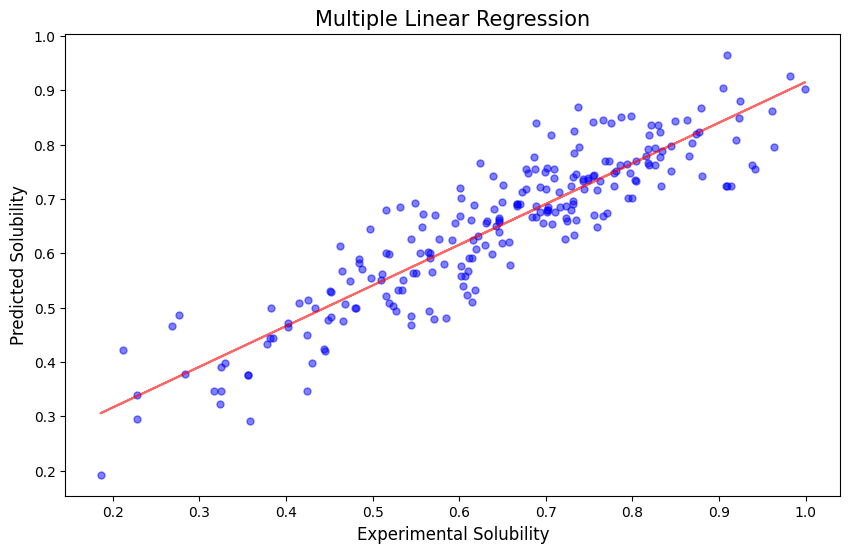

In [ ]:
#Linear Regression Model
# Train and evaluate linear regression model
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, Y_train)

Y_pred_test_lr = lr_model.predict(X_test)
lin_reg_mse = mean_squared_error(Y_test, Y_pred_test_lr)
lin_reg_r2 = r2_score(Y_test, Y_pred_test_lr)

print(f'Linear regression - MSE: {lin_reg_mse:.4f}')
print(f'Linear regression - R²: {lin_reg_r2:.4f}')

# Plot results
plt.figure(figsize=(10, 6))
slope_lin, intercept_lin = np.polyfit(Y_test, Y_pred_test_lr, 1)
plt.scatter(x=Y_test, y=Y_pred_test_lr, color='blue', s=25, alpha=0.5)
plt.plot(Y_test, slope_lin*Y_test + intercept_lin, color='red', alpha=0.6)
plt.xlabel('Experimental Solubility', fontsize=12)
plt.ylabel('Predicted Solubility', fontsize=12)
plt.title('Multiple Linear Regression', fontsize=15)
plt.show()

Feature Importances:


,importance
cLogP,0.826831
MolWeight,0.127888
numRotatableBonds,0.020188
AromaticProportion,0.025093



Random forest regression - MSE: 0.0023
Random forest regression - R²: 0.9160


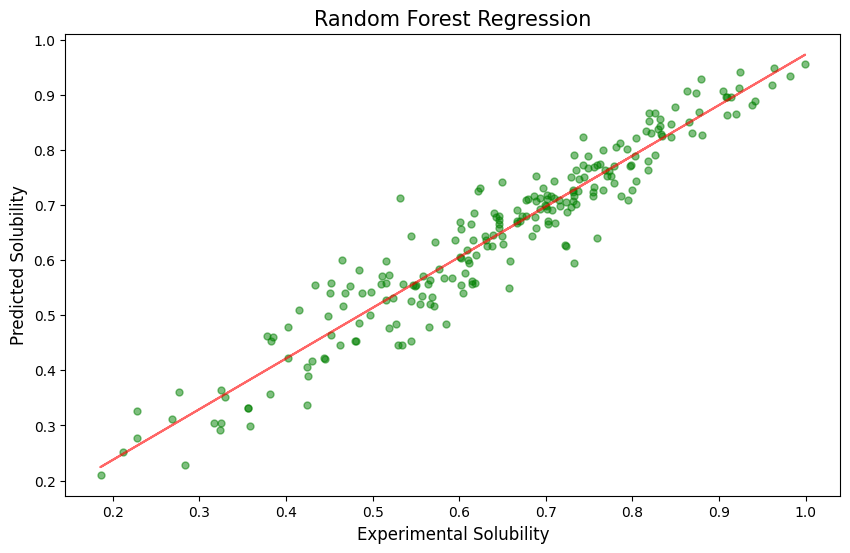

In [ ]:
#Random Forest Model
# Train and evaluate random forest model
rf_reg = RandomForestRegressor(random_state=SEED)
rf_reg.fit(X_train, Y_train)

Y_pred_rf_reg = rf_reg.predict(X_test)
rf_reg_mse = mean_squared_error(Y_test, Y_pred_rf_reg)
rf_reg_r2 = r2_score(Y_test, Y_pred_rf_reg)

# Display feature importances
feature_importance = pd.DataFrame(
    {'importance': rf_reg.feature_importances_},
    index=descriptors_df.iloc[:,:-1].columns
)
print("Feature Importances:")
display(feature_importance)

print(f'\nRandom forest regression - MSE: {rf_reg_mse:.4f}')
print(f'Random forest regression - R²: {rf_reg_r2:.4f}')

# Plot results
plt.figure(figsize=(10, 6))
slope_rf, intercept_rf = np.polyfit(Y_test, Y_pred_rf_reg, 1)
plt.scatter(x=Y_test, y=Y_pred_rf_reg, color='green', s=25, alpha=0.5)
plt.plot(Y_test, slope_rf*Y_test + intercept_rf, color='red', alpha=0.6)
plt.xlabel('Experimental Solubility', fontsize=12)
plt.ylabel('Predicted Solubility', fontsize=12)
plt.title('Random Forest Regression', fontsize=15)
plt.show()


Model Comparison Summary:


,Metric,Linear Regression,Random Forest
0,MSE,0.005345,0.002325
1,RMSE,0.073108,0.048214


<Figure size 1000x600 with 0 Axes>

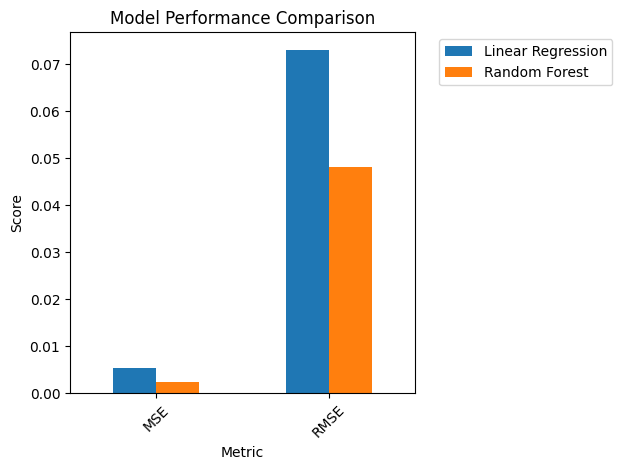

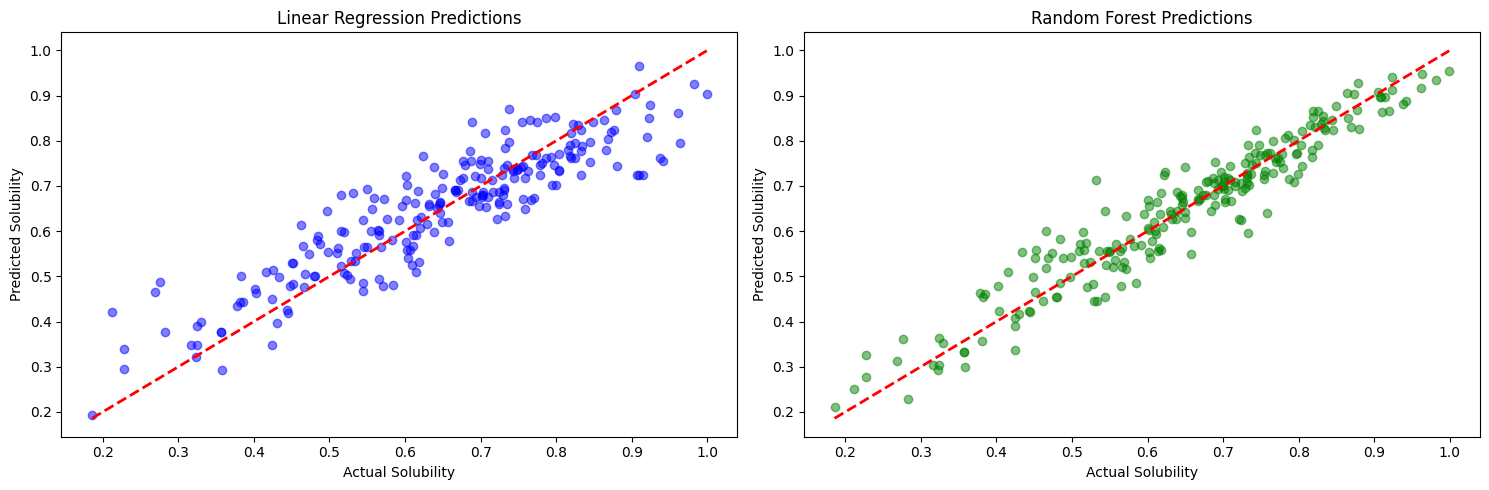

In [ ]:
# Model Comparison Summary
comparison_summary = pd.DataFrame({
    'Metric': ['MSE', 'RMSE'],
    'Linear Regression': [
        lin_reg_mse,  # MSE
        np.sqrt(lin_reg_mse),  # RMSE
    ],
    'Random Forest': [
        rf_reg_mse,  # MSE
        np.sqrt(rf_reg_mse),  # RMSE
    ]
})

print("\nModel Comparison Summary:")
display(comparison_summary)

# Visualize comparison
plt.figure(figsize=(10, 6))
comparison_summary.set_index('Metric').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot predictions side by side
plt.figure(figsize=(15, 5))

# Linear Regression subplot
plt.subplot(1, 2, 1)
plt.scatter(Y_test, Y_pred_test_lr, color='blue', alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Linear Regression Predictions')

# Random Forest subplot
plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_pred_rf_reg, color='green', alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Random Forest Predictions')

plt.tight_layout()
plt.show()


Reference: ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure (https://pubs.acs.org/doi/10.1021/ci034243x)
